#### PyNet: Building your own deep neural network with Numpy
##### Submission files:
- hw1.ipynb (with your completed code)
- PDF version of hw1.ipynb (with all results rendered)

##### Instructions:
- Complete the code below to train a deep neural network for binary classificaiton on a synthetic dataset.
- Design a deep neural network architecture for this binary classification task and achieve > 90% accuracy on test set.
- Note that to compute the backward pass, you might want to reuse some intermediate results from forward pass.

In [1]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm

### Parameter Class 
##### A class storing the parameter values and gradients in a Layer. 

In [2]:
class Parameter():
    """
    A class used to store parameters in a Layer.

    ...

    Attributes
    ----------
    val : np.array
        Values of learnable parameters. (e.g. weight/bias in linear layer) 
    grad: np.array
        Values of gradients required for training.

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    """
    def __init__(self, dim_shape):
        self.dim_shape = dim_shape
        self.val = np.zeros(dim_shape)
        self.grad = np.zeros_like(self.val)

### Layer Class 
##### An abstract class for all required computational modules in this assignment.

In [3]:
class Layer:
    """
    An abstract class for all required computational modules.

    ...

    Attributes
    ----------
    val : np.array
        Values of learnable parameters. (e.g. weight/bias in linear layer) 
    grad: np.array
        Values of gradients required for training.

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    forward()
        forward computation module.
    backward()
        backpropagation module.
    parameters()
        Get trainable parameters/gradients.
    """
    def __init__(self):
        pass

    def init_param(self):
        pass

    def forward(self):
        pass

    def backward(self):
        pass

    def parameters(self):
        pass

### (1) Linear Layer Class [10 points]
##### Instructions
- init_param
    - Use random initialization for the weights, e.g., np.random.randn()*0.1 with the correct shape.
    - Zero initialization for the biases.
- forward
    - Having initialized weight and bias, and given an input to the layer, compute the output of the layer.
- backward
    - Suppose you have an upstream gradient d_output = $\frac{\partial loss}{\partial output}$
    - Compute (d_input, d_weight, d_bias) using the chain rule.

In [4]:
class Linear(Layer):
    """
    Linear layer.

    ...

    Methods
    -------
    init_param()
        Initialize the layer parameters before training.
    forward()
        forward computation module.
    backward()
        backpropagation module.
    parameters()
        Get trainable parameters/gradients of weight and bias for optimization.
    """
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.init_param()

    def init_param(self):
        weights_dim_shape = (self.output_dim, self.input_dim)
        biases_dim_shape = (self.output_dim, 1)
        self.weights = Parameter(weights_dim_shape)
        self.weights.val = np.random.randn(self.output_dim, self.input_dim)*0.1 
        self.biases = Parameter(biases_dim_shape)
        
    def forward(self, input):
        self.x = input
        return np.dot(self.weights.val, input) + self.biases.val

    def backward(self, backward_input):
        self.weights.grad = np.dot(backward_input, self.x.T)
        self.biases.grad = backward_input.mean(axis=1, keepdims=True)
        grad = np.dot(self.weights.val.T, backward_input)
         
        return grad

    def parameters(self, learning_rate):
        #return [self.weights.val, self.weights.grad, self.biases.val, self.biases.grad]
        #Instead of returning trainable parameters I have the SGD class call this function
        #directly for optimization. I believe this way is cleaner. 
        #This allows for easier access to each layers weights and biases.
        self.weights.val = self.weights.val - learning_rate * self.weights.grad
        self.biases.val = self.biases.val - learning_rate * self.biases.grad


### (2) ReLU Class [5 points]
##### Instruction
- forward
    - Implement forward computation for a ReLU unit.
- backward
    - Implement backpropagation for a ReLU unit.

In [5]:
class ReLU(Layer):
    """
    ReLU activation unit.

    ...

    Methods
    -------
    forward()
        forward computation module.
    backward()
        backpropagation module.
    """
    def __init__(self):
        pass 

    def forward(self, input):
        self.input = input
        return np.maximum(0,self.input)

    def backward(self, backward_input):
        backward_input[self.input <= 0] = 0
        return backward_input 


### (3) Sigmoid Class [5 points]
##### Instructions
- forward
    - Implement forward computation for a sigmoid unit.
- backward
    - Implement backpropagation for a sigmoid unit.

In [6]:
class Sigmoid(Layer):
    """
    Sigmoid activation unit.

    ...

    Methods
    -------
    forward()
        forward computation module.
    backward()
        backpropagation module.
    """
    def __init__(self):
        pass

    def forward(self, input):
        self.input = input
        return 1/(1 + np.exp(-self.input))
        
    def backward(self, backward_input):
        prev = 1/(1 + np.exp(-self.input))
        return backward_input * prev * (1 - prev)


### (4) Binary Cross-Entropy Loss Class [10 points]
##### Instructions
- forward
    - Implement the forward computation to compute binary cross entropy loss: $y \log p + (1 - y) \log (1 - p)$
    - Input and label are both probability distributions
- backward
    - Implement backpropagation for binary cross-entropy.

In [7]:
class BinaryCrossEntropyLoss(Layer):
    def __init__(self):
        pass

    def forward(self, input, label):
        bce_loss = -(label * np.log(input) + (1 - label) * np.log(1 - input)).mean()
        return bce_loss

    def backward(self, input, label):
        num_labels = len(label) 
        grad = (-(label / input) + ((1 - label) / (1 - input))) / num_labels
        return grad

### (5) Stochastic Gradient Descent Optimizer [5 points]
##### Instructions
- step 
    - Update parameter values by their gradient.
    

In [8]:
class Optimizer_SGD():
    def __init__(self, param_list, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.param_list = param_list

    def step(self, layer):
        self.layer = layer 
        #the actual parameter update takes place within self.layer.parameters()
        self.layer.parameters(self.learning_rate)
        #for self.layer in self.layers:
          #if type(self.layer) is Linear:
            #dw = self.param_list[0]
            #db = self.param_list[0]
          #self.layer.weights.val = self.layer.weights.val - self.learning_rate * self.layer.weights.grad
          #self.layer.biases.val = self.layer.biases.val - self.learning_rate * self.layer.weights.grad

### (6) Model Class [15 points]
##### Instructions
- Build a deep model by stacking multiple Linear layers with non-linear activations
- Initialize the parameters for Linear layers.
- Implement the forward computation for the model.
- Implement backpropagation for the model.
- Your model architecture should be able to attain at least 90% test accuracy on the subsequent task.

In [9]:
class Model:
    """
    A deep neural network architecture for binary classification.

    ...

    Methods
    -------
    __init__()
        Define your own deep network by stacking modules above.
    forward()
        forward computation.
    backward()
        backpagation.
    parameters()
        return learnable parameters/gradients stored in all layers in model.
    """
    def __init__(self, layers, loss_fn, opt_fn):
        self.layers = layers 
        self.loss_fn = loss_fn 
        self.opt_fn = opt_fn
     
    def forward(self, input):
        for layer in self.layers:
            forward = layer.forward(input)
            input = forward
             
        return forward

    def backward(self, backward_input):
        bce_loss = self.loss_fn
        loss = bce_loss.forward(self.X, backward_input)
        grad = bce_loss.backward(self.X, backward_input)

        for layer in reversed(self.layers):
            if type(layer) is not Linear: 
                grad = layer.backward(grad)
            else:
                grad = layer.backward(grad)
                self.opt_fn.step(layer)

        return loss

    def parameters(self):
        #Instead of returning learnable parameters stored in all layers in model,
        #I decided to use sgd call to modify parameters directly via Linear.parameters(). 
        #Thus, this function is unnecessary.
        #params = []
        #for layer in self.layers:
        #  params.append(layer.parameters())
        #return params
        pass

### Generate Training Data
* Here, we generate 2D data points for binary classification.
* This data is not linearly separable, and therefore, you will need to build a multi-layer network with non-linear activations to fit the data.

In [10]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

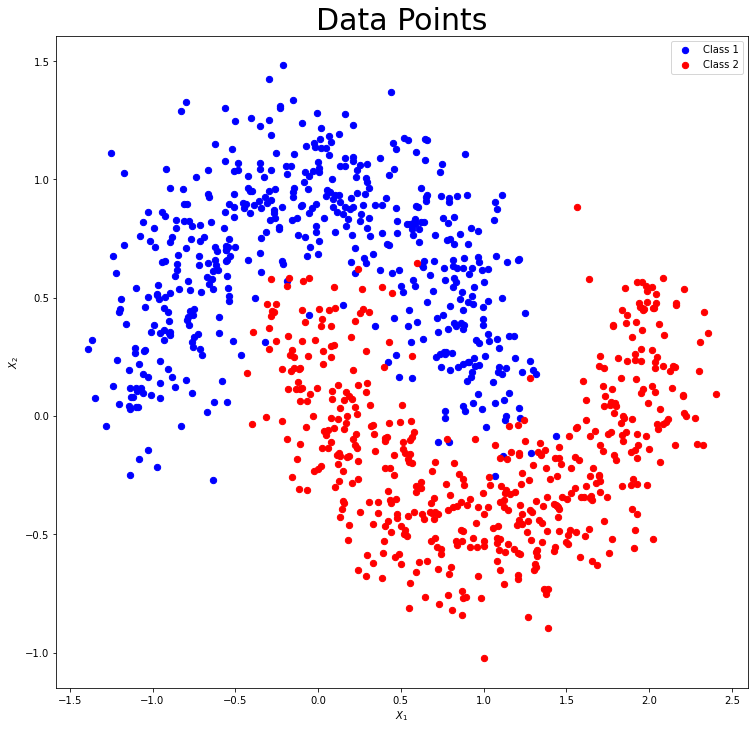

In [11]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], s=40, c = 'blue', label = 'Class 1')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], s=40, c = 'red', label = 'Class 2')
    plt.legend()
    plt.show()
make_plot(X, y, 'Data Points')

### (7) Training and Testing the Model [15 points]
- Implement the training loop to optimize your model's parameters over multiple epochs.
- You can experiment with training strategy, e.g., batch size, epochs, learning rate, and model architecture to achieve the best performance.
- Note that you can modify the input shape to fit your implementation.
- Implement a fuction that runs a trained model on test data and returns accuracy.

In [17]:
loss_fn = BinaryCrossEntropyLoss()
architecture = [Linear(2, 4), ReLU(), Linear(4,8), ReLU(), Linear(8,16), ReLU(), Linear(16,4), ReLU(), Linear(4,1), Sigmoid()]
optimizer = Optimizer_SGD([], learning_rate=0.04)
model = Model(layers=architecture, loss_fn=loss_fn, opt_fn=optimizer)

def train(X, Y, model, loss_fn, optimizer, epochs=10000):
    for epoch in range(epochs):
        forward = model.forward(X)
        model.X = forward

        loss = model.backward(Y)
        #optimizer.step()

        if epoch % 1000 == 0:
            print('Epoch: {} / Loss: {}'.format(epoch,loss))  

train(X_train.T,   y_train,  model, loss_fn,  optimizer, epochs=35000)
    
def get_test_accuracy(model, X_test, y_test):
    preds = model.forward(X_test.T).T
    rounded_preds = []

    for p in preds:
        if p < 0.5:
            rounded_preds.append(0)
        else:
            rounded_preds.append(1)

    correct = 0
    total = len(y_test)
    for i in range(total):
        if rounded_preds[i] == y_test[i]:
            correct = correct + 1

    return (correct/total)

accuracy = get_test_accuracy(model, X_test, y_test)
print('Model accuracy: {}'.format(accuracy))
    

Epoch: 0 / Loss: 0.693162121659307
Epoch: 1000 / Loss: 0.693151200851212
Epoch: 2000 / Loss: 0.6931429198373397
Epoch: 3000 / Loss: 0.6931374810817065
Epoch: 4000 / Loss: 0.6931317551913238
Epoch: 5000 / Loss: 0.6931253755609785
Epoch: 6000 / Loss: 0.6931179744853256
Epoch: 7000 / Loss: 0.6931099432962123
Epoch: 8000 / Loss: 0.693100778250597
Epoch: 9000 / Loss: 0.6930902270397347
Epoch: 10000 / Loss: 0.6930769393006391
Epoch: 11000 / Loss: 0.6930595514119529
Epoch: 12000 / Loss: 0.6930361310352825
Epoch: 13000 / Loss: 0.6930035653554703
Epoch: 14000 / Loss: 0.692956482453831
Epoch: 15000 / Loss: 0.6928852246232456
Epoch: 16000 / Loss: 0.6927701591274664
Epoch: 17000 / Loss: 0.6925642430854838
Epoch: 18000 / Loss: 0.6920921239056942
Epoch: 19000 / Loss: 0.689799743634063
Epoch: 20000 / Loss: 0.4923588197025232
Epoch: 21000 / Loss: 0.4881540119100169
Epoch: 22000 / Loss: 0.48105263363152584
Epoch: 23000 / Loss: 0.4740232456307919
Epoch: 24000 / Loss: 0.46707782528610725
Epoch: 25000 / L

### Visualization: Plot the Decision Boundary

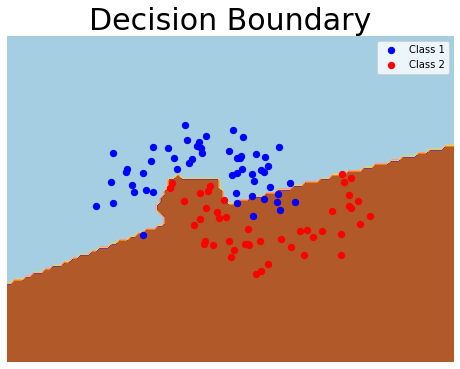

In [18]:
def plot_decision_boundary(model, X_train, Y_train, X_test, Y_test):
    # function to draw the model's decision boundary
    h = 0.05
    X = np.concatenate([X_train, X_test], axis = 0)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    input = np.stack([xx,yy], axis = -1).reshape(-1,2)
    pred = model.forward(input.transpose(1,0))
    index = pred >= 0.5
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    plt.title('Decision Boundary', fontsize=30)
    ax.contourf(xx, yy, index.reshape(xx.shape), cmap=plt.cm.Paired)
    ax.axis('off')
    ax.scatter(X_test[Y_test == 0,0], X_test[Y_test == 0,1], s = 40,  c = 'blue', label = 'Class 1')
    ax.scatter(X_test[Y_test == 1,0], X_test[Y_test == 1,1], s = 40, c = 'red', label = 'Class 2')
    plt.legend()
    plt.show()

plot_decision_boundary(model, X_train, y_train, X_test, y_test)